# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Environments

In [41]:
class LinearEnv:
    """
    State Index:   [ 0    1    2    3    4    5    6 ]
    State Label:   [ .    A    B    C    D    E    . ]
    Type:          [ T    .    .    S    .    .    T ]    
    """
    V_true =       [0.0, 1/6, 2/6, 3/6, 4/6, 5/6, 0.0]
    
    def __init__(self):
        self.nb_st = (7,)
        self.nb_act = 2
        self.st_space = list(range(7))
        self.act_space = [0, 1]  # LEFT = 0, RIGHT = 1
        self.reset()

    def reset(self):
        self._state = 1  # np.random.randint(1, 5+1)
        self._done = False
        return self._state

    def step(self, action):
        if self._done: raise ValueError('Episode has terminated')
        if action not in [0, 1]: raise ValueError('Invalid action')

        if action == 0: self._state -= 1
        if action == 1: self._state += 1
            
        reward = -0.1
        if self._state < 1: self._done = True
        if self._state > 5: self._done = True; reward = 1.0
                
        return self._state, reward, self._done, None  # obs, rew, done, debug

In [3]:
class BanditEnv:
    def __init__(self, offset=0.0, variance=1.0):
        """10-armed testbed, see chapter 2.3"""
        self.nb_st = (1,)
        self.nb_act = 10    # 10 arms
        self.st_space = [0]
        self.means = np.array([0.25, -0.75, 1.5, 0.5, 1.25,   # eyeball fig 2.1
                               -1.5, -0.25, -1, 0.75, -0.5]) * variance + offset
        # self.means = np.random.randn(10) * variance + offset
    
    def reset(self):
        return 0  # observation
        
    def step(self, action):
        # observation, reward, done, extra
        return 0, np.random.normal(loc=self.means[action]), True, None

In [4]:
class CorridorSwitchedEnv:
    """Short corridor with switched actions. See example 13.1 in the book.
    
    Note: Small change introduced to terminate after time step 1000
          to prevent infinite loop if policy becomes deterministic.
    """
    def __init__(self):
        self.nb_st = (1,)
        self.nb_act = 2
        self.st_space = [0]
        self._state = 0
        self._curr_iter = 0
        
    def reset(self):
        self._state = 0
        self._curr_iter = 0
        return 0    # states are indistinguisable
    
    def step(self, action):
        assert action in [0, 1]    # left, right
        
        if self._state == 0:
            if action == 1:
                self._state = 1
        elif self._state == 1:
            if action == 0:        # left, swapped to right
                self._state = 2
            else:                  # right, swapped to left
                self._state = 0
        elif self._state == 2:
            if action == 0:
                self._state = 1
            else:
                self._state = 3    # terminal
        else:
            raise ValueError('Invalid state:', self._state)
        
        # Terminate at time step = 1000
        self._curr_iter += 1
        if self._curr_iter >= 1000:
            self._state = 3
        
        if self._state == 3:
            return 0, -1.0, True, None    # obs, reward, done, extra
        else:
            return 0, -1.0, False, None

In [102]:
import matplotlib.patches as patches
from collections import defaultdict

In [214]:
class CliffWalkingEnv:
    def __init__(self):
        self.nb_st = (12, 4)
        self.nb_act = 4
        self.act_space = [0, 1, 2, 3]  # LEFT = 0, DOWN = 1, RIGHT = 2, UP = 3
        self.reset()
        
    def reset(self):
        self._x, self._y = 0, 0        # agent initial position
        return (0, 0)
        
    def step(self, action):
        """actions: LEFT = 0, DOWN = 1, RIGHT = 2, UP = 3"""
        self._x, self._y = self.transition(self._x, self._y, action)
        
        if self._x in range(1,11) and self._y == 0:  # CLIFF spanning x=[1..10]
            self._x, self._y = 0, 0                  #  teleport to start
            return (self._x, self._y), -100.0, False, None   #  return -100 reward
        if self._x == 11 and self._y == 0:           # GOAL at (11,0)
            return (self._x, self._y), -1.0, True, None      #  -1, terminate
        return (self._x, self._y), -1.0, False, None         # NORMAL states
        
    def transition(self, x, y, action):
        """Perform transition from [x,y] given action. Does not teleport."""
        
        if action == 0:    x -= 1     # left
        elif action == 1:  y -= 1     # down
        elif action == 2:  x += 1     # right
        elif action == 3:  y += 1     # up
        else: raise ValueError('Action must be in [0,1,2,3]')
            
        x = np.clip(x, 0, 11)   # x range is [0..11] incl.
        y = np.clip(y, 0, 3)    # y range is [0..3] incl.
        return x, y
    
    def get_path(self, Q):
        """Returns a path agent would take, if following greedy Q-based policy"""
        x, y = 0, 0       # agent starting position
        path = [(x, y)]   # save starting position
        for _ in range(100):  # limit steps in case policy is loopy
            A_star = np.argmax([Q[(x,y)][a] for a in [0, 1, 2, 3]])   # pick best action
            x, y = self.transition(x, y, A_star)         # take one step
            path.append((x,y))                           # save to path
            if x in range(1,11) and y == 0:              # CLIFF
                path.append((0, 0))                      # teleport
            if x == 11 and y == 0:  break                # GOAL at (11,0)
        return path

In [236]:
def plot_cliffwalk(Q=None, path_blue=None, path_red=None, labels=None, saveimg=None):
    """Plot windy gridworld.
    
    Will plot optimal action for each cell, according to 'Q'
    and blue/red lines following 'path_blue'/'path_red' parameters
    
    Params:
        Q         - optional, dictionary mappting [(x,y),action] -> float
        path_blue - optional, list [(x1,y1), (x2,y2), ...] of agent steps
        path_red  - optional, list [(x1,y1), (x2,y2), ...] of agent steps
        labels    - tuple of 2x strings, e.g. ('Sarsa', 'Q-Learning')
    """
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.set_xlim(-.5, 11.5)   # cliffwalk x range [0..11]
    ax.set_ylim(-.5, 3.5)    #           y range [0..3]
    ax.set_yticks([])
    ax.set_xticks([])
    ax.axis('off')
    ax.set_aspect('equal', 'datalim')

    # Start, Goal, The Cliff markers
    params = {'horizontalalignment':'center', 'verticalalignment':'center'}
    ax.text(0, 0, 'S', fontsize=18, horizontalalignment='center', verticalalignment='center')
    ax.text(11, 0, 'G', fontsize=18, horizontalalignment='center', verticalalignment='center')
    ax.text(5.5, 0, 'T h e   C l i f f', fontsize=18, **params)
    
    for x in range(12):
        for y in range(4):
            if x not in [0, 11] and y == 0:  # cliff
                ax.add_patch(patches.Rectangle([x-0.5, y-0.5], 1, 1, fill=True, color='lightgray'))    
            else:
                ax.add_patch(patches.Rectangle([x-0.5, y-0.5], 1, 1, fill=False))  # cells

            if Q is not None:
                params = {'head_width':0.2, 'head_length':0.2, 'color':'gray', 'alpha':.2}
                A_star = np.argmax([Q[(x,y)][a] for a in [0, 1, 2, 3]])  # pick best action
                if A_star == 3:    ax.arrow(x, y, 0,  .1, **params)  # up
                elif A_star == 1:  ax.arrow(x, y, 0, -.1, **params)  # down
                elif A_star == 0:  ax.arrow(x, y, -.1, 0, **params)  # left
                elif A_star == 2:  ax.arrow(x, y,  .1, 0, **params)  # right

    # plot blue line
    if path_blue is not None:
        for i in range(len(path_blue)-1):
            x, y = path_blue[i]
            x_, y_ = path_blue[i+1]
            if labels is not None and i == 0:
                ax.plot([x, x_], [y, y_], color='blue', alpha=1., label=labels[0])
            else:
                ax.plot([x, x_], [y, y_], color='blue', alpha=1.)

    # plot red line
    if path_red is not None:
        for i in range(len(path_red)-1):
            x, y = path_red[i]
            x_, y_ = path_red[i+1]
            if labels is not None and i == 0:
                ax.plot([x, x_], [y, y_], color='red', alpha=1., label=labels[1])
            else:
                ax.plot([x, x_], [y, y_], color='red', alpha=1.)

    # fig.legend(loc=4)
                
    plt.tight_layout()
    if saveimg is not None:
        plt.savefig(saveimg)
    plt.show()

# Algorithms

### Actor-Critic

In [293]:
# see e.g. here: https://deepnotes.io/softmax-crossentropy
def softmax(x):
    """Numerically stable softmax"""
    max_ = np.max(x, axis=-1, keepdims=True)       #                  shape: (n_batch, 1)
    ex = np.exp(x - max_)                          #                  shape: (n_batch, n_out)
    ex_sum = np.sum(ex, axis=-1, keepdims=True)    #                  shape: (n_batch, 1)
    return ex / ex_sum                             # probabilities    shape: (n_batch, n_out)

def test_softmax():
    probabilities = [0.1, 0.2, 0.3, 0.4]  # log is inverse of softmax
    assert np.allclose(softmax(np.log(probabilities)), probabilities)
    print('PASS')
test_softmax()

PASS


In [278]:
class TabularStateValueFunction:
    """Tabular state-value function 'approximator'"""
    def __init__(self, lr, nb_states):
        assert isinstance(lr, float)
        assert isinstance(nb_states, tuple)
        self._lr = lr
        self._w = np.zeros(nb_states)
    
    def evaluate(self, state):
        assert isinstance(state, (int, tuple))
        assert self._w.ndim == 1 if isinstance(state, int) else len(state)
        # or onehot(state, nb_states) @ self._w
        return self._w[state]
    
    def evaluate_all(self):
        return self._w.copy()
    
    def train(self, state, target):
        assert isinstance(state, (int, tuple))
        assert self._w.ndim == 1 if isinstance(state, int) else len(state)
        assert isinstance(target, float)
        value = self.evaluate(state)
        self._w[state] += self._lr * (target - value)

def test_tsvf():
    # Test 1D case, state is int
    tsvf = TabularStateValueFunction(lr=0.1, nb_states=(2,))
    tsvf.train(1, 1.0)
    assert tsvf.evaluate(0) == 0.0
    assert tsvf.evaluate(1) == 0.1
    
    # Test 2D case, state is tuple
    tsvf = TabularStateValueFunction(lr=0.1, nb_states=(2,2))
    tsvf.train((0,1), 1.0)
    tsvf.train((1,0), 2.0)
    tsvf.train((1,1), 4.0)
    assert tsvf.evaluate((0,0)) == 0.0
    assert tsvf.evaluate((0,1)) == 0.1
    assert tsvf.evaluate((1,0)) == 0.2
    assert tsvf.evaluate((1,1)) == 0.4

    print('PASS')
test_tsvf()

PASS


In [294]:
class TabularSoftmaxPolicy:
    """Tabular action-state function 'approximator'"""
    def __init__(self, lr, nb_states, nb_actions, init_theta=None):
        assert isinstance(lr, float)
        assert isinstance(nb_states, tuple)
        assert isinstance(nb_actions, int)
        self._lr = lr                                   # learning rate
        self.n_act = nb_actions
        self._theta = np.zeros((*nb_states, nb_actions))  # weights
        if init_theta is not None:
            assert init_theta.dtype == np.float64
            assert init_theta.shape == self._theta.shape
            self._theta = init_theta
    
    def pi(self, state):
        """Return policy, i.e. probability distribution over actions."""
        assert isinstance(state, (int, tuple))
        assert self._theta.ndim == 2 if isinstance(state, int) else len(state)+1
        
        h_vec = self._theta[state]
        prob_vec = softmax(h_vec)                     # shape=[n_act], e.q. 13.2
        assert prob_vec[0] != 0.0 and prob_vec[0] != 1.0
        assert prob_vec[1] != 0.0 and prob_vec[1] != 1.0
        
        assert prob_vec.ndim == 1
        return prob_vec
    
    def pi_all(self):
        return softmax(self._theta)

    def update(self, state, action, disc_return):
        x_s = np.zeros(self.n_act)
        x_s[action] = 1             # feature vector, one-hot
        prob = self.pi(state)
        grad_s = x_s - prob
        self._theta[state] += self._lr * disc_return * grad_s

In [11]:
def test_tsp():
    tsp = TabularSoftmaxPolicy(lr=0.1, nb_states=(2,), nb_actions=2)
    tsp.update(state=1, action=0, disc_return=3.0)
    tsp.update(state=1, action=1, disc_return=6.0)
    assert np.allclose(tsp.pi(0), np.array([0.5, 0.5]))
    assert np.allclose(tsp.pi(1), np.array([0.40387835, 0.59612165]))
    
    tsp = TabularSoftmaxPolicy(lr=0.1, nb_states=(2,2), nb_actions=2)
    tsp.update(state=(1,1), action=0, disc_return=3.0)
    tsp.update(state=(1,1), action=1, disc_return=6.0)
    assert np.allclose(tsp.pi((0,0)), np.array([0.5, 0.5]))
    assert np.allclose(tsp.pi((1,1)), np.array([0.40387835, 0.59612165]))

    print('PASS')
test_tsp()

PASS


In [295]:
def one_step_actor_critic(env, ep, gamma, alpha_w, alpha_theta, init_theta=None):
    """Sarsa (on-policy TD control)
    
    Params:
        env - environment
        ep - number of episodes to run
        gamma - discount factor [0..1]
        alpha_w (float): learning rate for state-value function
        alpha_theta (float): learning rate for policy
        init_theta (np.array): initialize policy weights, default np.zeros()
    """
    def policy(st, pi):
        return np.random.choice(range(env.nb_act), p=pi.pi(st))
    
    hist_R = []
    hist_val = []
    hist_prob = []
    
    v_hat = TabularStateValueFunction(lr=alpha_w, nb_states=env.nb_st)
    pi = TabularSoftmaxPolicy(lr=alpha_theta, nb_states=env.nb_st,
                              nb_actions=env.nb_act, init_theta=init_theta)
    
    for _ in range(ep):
        S = env.reset()
        I = 1
        
        R_sum = 0
        while True:
            A = policy(S, pi)
            S_, R, done, _ = env.step(A)
            
            target = R + gamma*v_hat.evaluate(S_) if not done else R
            delta = target - v_hat.evaluate(S)
            
            v_hat.train(S, target)
            pi.update(S, A, I*delta)
            
            I *= gamma
            S = S_
            
            R_sum += R
            if done: break
        
        hist_R.append(R_sum)
        hist_val.append(v_hat.evaluate_all())
        hist_prob.append(pi.pi_all())
        if hasattr(env, 'st_space'):
            #hist_val.append([v_hat.evaluate(s) for s in env.st_space])
            #hist_prob.append([pi.pi(s) for s in env.st_space])
            pass
    
    hist_R = np.array(hist_R)
    hist_val = np.array(hist_val)
    hist_prob = np.array(hist_prob)
    
    return hist_R, hist_val, hist_prob, {'v_hat': v_hat, 'pi': pi}

### SARSA

In [195]:
def argmax_rand(a):
    """Break ties randomly, (np.argmax always picks first max)."""
    assert isinstance(a, list) or a.ndim == 1
    return np.random.choice(np.flatnonzero(a == np.max(a)))

In [200]:
def Q_table_to_probabilities(Q, eps):
    assert Q.ndim >= 2
    
    state_shape = Q.shape[:-1]
    nb_act = Q.shape[-1]
    
    amax_flat = np.argmax(Q, axis=-1).flatten()  # shape[prod(*nb_st)] 1D
    one_hot = np.eye(nb_act)[amax_flat]  # shape [prod(*nb_st), nb_act] 2D
    probs = one_hot.reshape(*state_shape, -1)  # shape [*nb_st, nb_act] ND
    probs *= 1.0 - eps
    probs += eps / Q.shape[-1]
    assert probs.shape == Q.shape
    assert np.all(probs.sum(axis=-1) == 1.0)
    return probs

In [205]:
def sarsa(env, ep, gamma, alpha, eps):
    """Sarsa (on-policy TD control)
    
    Params:
        env - environment
        ep - number of episodes to run
        gamma - discount factor [0..1]
        alpha - step size (0..1]
        eps - epsilon-greedy param
    """
    def policy(st, Q, eps):
        if np.random.rand() > eps:
            X = argmax_rand(Q[st])
        else:
            X = np.random.randint(env.nb_act)
        return X
    
    hist_R = []
    hist_Q = []
    hist_P = []
    
    Q = np.zeros((*env.nb_st, env.nb_act))  # default zero for all
    N = np.zeros((*env.nb_st, env.nb_act))
    
    for _ in range(ep):
        S = env.reset()
        A = policy(S, Q, eps)
        
        R_sum = 0.0
        while True:
            S_, R, done, _ = env.step(A)
            A_ = policy(S_, Q, eps)
            Q_next = Q[S_][A_] if not done else 0.0
            assert not done or Q_next == 0.0
            Q[S][A] = Q[S][A] + alpha * (R + gamma * Q_next - Q[S][A])
            N[S][A] += 1
            S, A = S_, A_
            
            R_sum += R
            
            if done:
                break
        
        hist_R.append(R_sum)
        hist_Q.append(Q.copy())
        hist_P.append(Q_table_to_probabilities(Q, eps))
    
    hist_R = np.array(hist_R)
    hist_Q = np.array(hist_Q)
    hist_P = np.array(hist_P)
                
    return Q, N, hist_R, hist_Q, hist_P

# Experiments

### Bandits

In [299]:
env = BanditEnv()

In [300]:
hist_R, hist_val, hist_prob, extra_dict = one_step_actor_critic(env, ep=1000, gamma=1.0, alpha_w=2**-4, alpha_theta=2**-2)

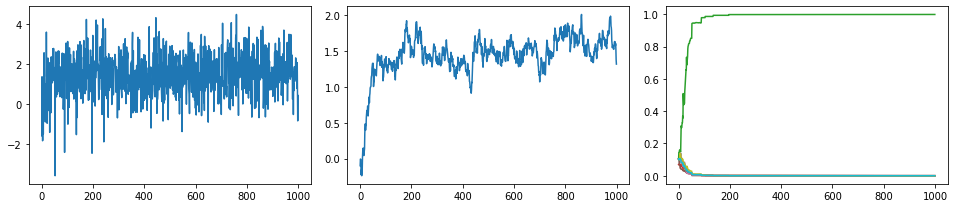

In [301]:
_, (axR, axV, axP) = plt.subplots(ncols=3, figsize=(13.4,3))
axR.plot(hist_R)
axV.plot(hist_val)
axP.plot(hist_prob[:,0])
plt.tight_layout()
plt.show()

### Linear

In [287]:
env = LinearEnv()
Q, N, hist_R, hist_Q, hist_P = sarsa(env, 2000, gamma=1., alpha=.5, eps=.1)

In [288]:
hist_V = np.sum(hist_Q * hist_P, axis=-1)

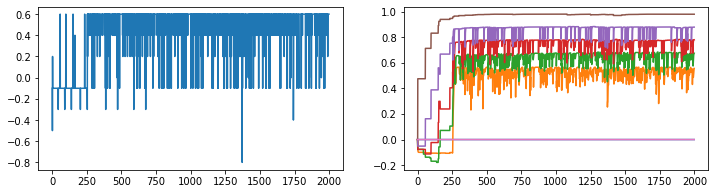

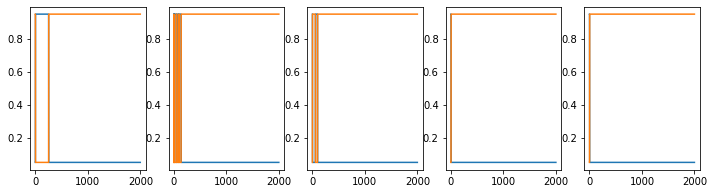

In [289]:
_, (axR, axV) = plt.subplots(ncols=2, figsize=(12,3))
axR.plot(hist_R)
axV.plot(hist_V)
plt.show()
_, axes = plt.subplots(ncols=5, figsize=(12,3))
for i, ax in enumerate(axes, start=1):
    ax.plot(hist_P[:,i])
plt.show()

In [302]:
env = LinearEnv()

In [303]:
hist_R, hist_val, hist_prob, extra_dict = one_step_actor_critic(env, ep=2000, gamma=1.0, alpha_w=2**-2, alpha_theta=2**-4)

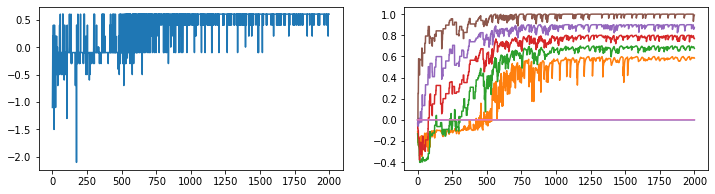

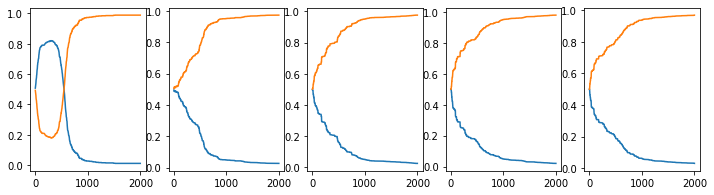

In [304]:
_, (axR, axV) = plt.subplots(ncols=2, figsize=(12,3))
axR.plot(hist_R)
axV.plot(hist_val)
plt.show()
_, axes = plt.subplots(ncols=5, figsize=(12,3))
for i, ax in enumerate(axes, start=1):
    ax.plot(hist_prob[:,i])
plt.show()

### CliffWalking

In [540]:
env = CliffWalkingEnv()

In [541]:
Q, N, hist_R, hist_Q, hist_P = sarsa(env, 5000, gamma=1., alpha=.1, eps=.1)

In [542]:
hist_V = np.sum(hist_Q * hist_P, axis=-1)

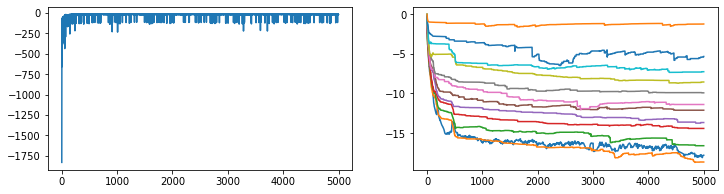

In [543]:
_, (axR, axV) = plt.subplots(ncols=2, figsize=(12,3))
axR.plot(hist_R)
axV.plot(hist_V[:,:,1])
plt.show()
# _, axes = plt.subplots(ncols=5, figsize=(12,3))
# for i, ax in enumerate(axes, start=1):
#     ax.plot(hist_P[:,i])
# plt.show()

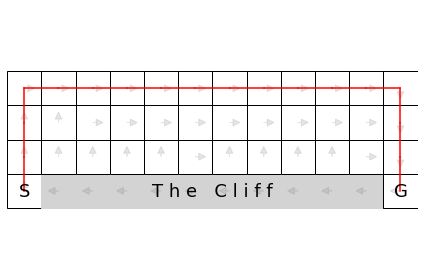

In [544]:
path = env.get_path(Q)
plot_cliffwalk(Q, path_red=path)

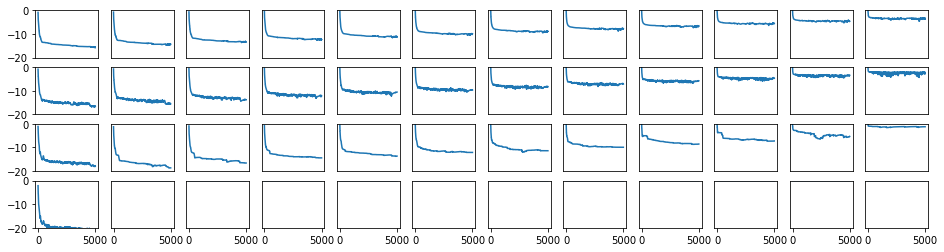

In [545]:
_, axes = plt.subplots(ncols=12, nrows=4, figsize=(16,4))
for x in range(12):
    for y in range(4):
        ax = axes[3-y, x]
        ax.plot(hist_V[:,x,y])
        if y != 0:
            ax.set_xticks([], [])
        if x != 0:
            ax.set_yticks([], [])
        ax.set_ylim(-20, 0)

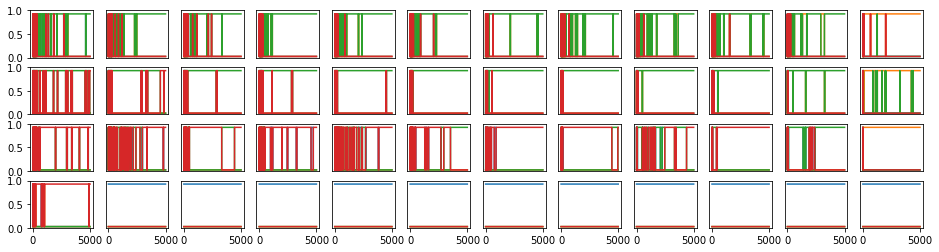

In [546]:
_, axes = plt.subplots(ncols=12, nrows=4, figsize=(16,4))
for x in range(12):
    for y in range(4):
        ax = axes[3-y, x]
        ax.plot(hist_P[:,x,y,:])
        if y != 0:
            ax.set_xticks([], [])
        if x != 0:
            ax.set_yticks([], [])
        ax.set_ylim(0, 1)

In [479]:
env = CliffWalkingEnv()

In [501]:
#hist_R, hist_val, hist_prob, extra_dict = one_step_actor_critic(env, ep=5000, gamma=1.0, alpha_w=2**-6, alpha_theta=2**-9)
#hist_R, hist_val, hist_prob, extra_dict = one_step_actor_critic(env, ep=5000, gamma=1.0, alpha_w=2**-8, alpha_theta=2**-9)
#hist_R, hist_val, hist_prob, extra_dict = one_step_actor_critic(env, ep=5000, gamma=1.0, alpha_w=2**-9, alpha_theta=2**-9)
hist_R, hist_val, hist_prob, extra_dict = one_step_actor_critic(env, ep=5000, gamma=1.0, alpha_w=2**-9, alpha_theta=2**-8)

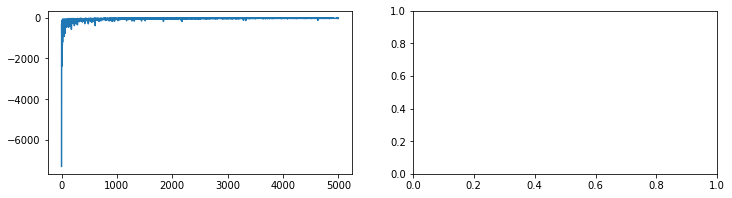

In [502]:
_, (axR, axV) = plt.subplots(ncols=2, figsize=(12,3))
axR.plot(hist_R)
# axV.plot(hist_val[:,:,1])
plt.show()
# _, axes = plt.subplots(ncols=5, figsize=(12,3))
# for i, ax in enumerate(axes, start=1):
#     ax.plot(hist_P[:,i])
# plt.show()

In [503]:
pi = extra_dict['pi']

In [504]:
Q = np.zeros((*env.nb_st, env.nb_act))
for x in range(12):
    for y in range(4):
        A = argmax_rand(pi.pi((x,y)))
        Q[(x,y)][A] = 1.0

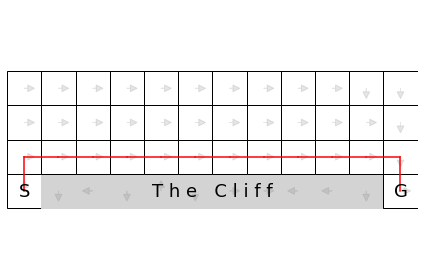

In [505]:
path = env.get_path(Q)
plot_cliffwalk(Q, path_red=path)

In [506]:
hist_val[-1].shape

(12, 4)

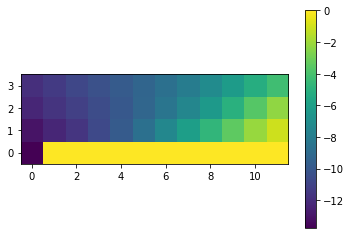

In [507]:
plt.imshow(hist_val[-1].T, origin='lower')
plt.colorbar()

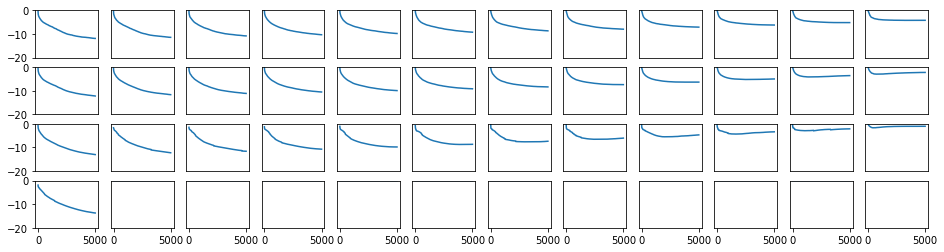

In [519]:
_, axes = plt.subplots(ncols=12, nrows=4, figsize=(16,4))
for x in range(12):
    for y in range(4):
        ax = axes[3-y, x]
        ax.plot(hist_val[:,x,y])
        if y != 0:
            ax.set_xticks([], [])
        if x != 0:
            ax.set_yticks([], [])
        ax.set_ylim(-20, 0)

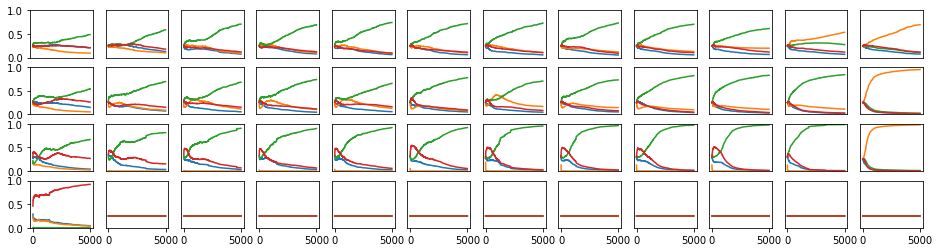

In [520]:
_, axes = plt.subplots(ncols=12, nrows=4, figsize=(16,4))
for x in range(12):
    for y in range(4):
        ax = axes[3-y, x]
        ax.plot(hist_prob[:,x,y,:])
        if y != 0:
            ax.set_xticks([], [])
        if x != 0:
            ax.set_yticks([], [])
        ax.set_ylim(0, 1)

In [437]:
#        3 red
# 0 blue          2 green
#        1 orange

In [438]:
hist_prob.shape

(5000, 12, 4, 4)